# Factor Graphs


### Preliminaries

- Goal 
  - Introduction to Forney-style factor graphs and message passing-based inference 
- Materials        
  - Mandatory
    - These lecture notes   
    - Loeliger (2007), [The factor graph approach to model based signal processing](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Loeliger-2007-The-factor-graph-approach-to-model-based-signal-processing.pdf), pp. 1295-1302 (until section V)
  - Optional
    - Frederico Wadehn (2015), [Probabilistic graphical models: Factor graphs and more](https://www.youtube.com/watch?v=Fv2YbVg9Frc&t=31) video lecture (**highly recommended**)
  - References
    - Forney (2001), [Codes on graphs: normal realizations](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Forney-2001-Codes-on-graphs-normal-realizations.pdf)
    - Zhang et al. (2017), [Unifying Message Passing Algorithms Under the Framework of Constrained Bethe Free Energy Minimization](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Zhang-2017-Unifying-Message-Passing-Algorithms.pdf)
    - Dauwels (2007), [On variational message passing on factor graphs](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Dauwels-2007-on-variational-message-passing-on-factor-graphs)
    - Caticha (2010), [Entropic Inference](https://arxiv.org/abs/1011.0723)

### Why Factor Graphs?

- A probabilistic inference task gets its computational load mainly through the need for marginalization (i.e., computing integrals). E.g., for a model $p(x_1,x_2,x_3,x_4,x_5)$, the inference task $p(x_2|x_3)$ is given by 

$$\begin{align*}
p(x_2|x_3) = \frac{\idotsint p(x_1,x_2,x_3,x_4,x_5) \, \mathrm{d}x_1  \mathrm{d}x_4 \mathrm{d}x_5}{\idotsint p(x_1,x_2,x_3,x_4,x_5) \, \mathrm{d}x_1  \mathrm{d}x_2 \mathrm{d}x_4 \mathrm{d}x_5}
\end{align*}$$

- Since these computations suffer from the "curse of dimensionality", we often need to solve a simpler problem in order to get an answer. 

- Factor graphs provide a computationally efficient approach to solving inference problems **if the generative distribution can be factorized**. 

- Factorization helps. For instance, if $p(x_1,x_2,x_3,x_4,x_5) = p(x_1)p(x_2,x_3)p(x_4)p(x_5|x_4)$, then

$$\begin{align*}
p(x_2|x_3) &= \frac{\idotsint p(x_1)p(x_2,x_3)p(x_4)p(x_5|x_4) \, \mathrm{d}x_1  \mathrm{d}x_4 \mathrm{d}x_5}{\idotsint p(x_1)p(x_2,x_3)p(x_4)p(x_5|x_4) \, \mathrm{d}x_1  \mathrm{d}x_2 \mathrm{d}x_4 \mathrm{d}x_5} 
  = \frac{p(x_2,x_3)}{\int p(x_2,x_3) \mathrm{d}x_2}
\end{align*}$$

which is computationally much cheaper than the general case above.

- In this lesson, we discuss how computationally efficient inference in *factorized* probability distributions can be automated by message passing-based inference in factor graphs.

###  Factor Graph Construction Rules

- Consider a function 
$$
f(x_1,x_2,x_3,x_4,x_5) = f_a(x_1,x_2,x_3) \cdot f_b(x_3,x_4,x_5) \cdot f_c(x_4)
$$

- The factorization of this function can be graphically represented by a **Forney-style Factor Graph** (FFG):

<img src="./figures/ffg-example-1.png" width="400px">

- An FFG is an **undirected** graph subject to the following construction rules ([Forney, 2001](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Forney-2001-Codes-on-graphs-normal-realizations.pdf))

  1. A **node** for every factor;
  1. An **edge** (or **half-edge**) for every variable;
  1. Node $g$ is connected to edge $x$ **iff** variable $x$ appears in factor $g$.

### Some FFG Terminology

- $f$ is called the **global function** and $f_\bullet$ are the **factors**. 

- A **configuration** is an assigment of values to all variables.

- The **configuration space** is the set of all configurations, i.e., the domain of $f$

- A configuration $\omega=(x_1,x_2,x_3,x_4,x_5)$ is said to be **valid** iff $f(\omega) \neq 0$
  

###  Equality Nodes for Branching Points


- Note that a variable can appear in maximally two factors in an FFG (since an edge has only two end points).

- Consider the factorization (where $x_2$ appears in three factors) 

$$
 f(x_1,x_2,x_3,x_4) = f_a(x_1,x_2)\cdot f_b(x_2,x_3) \cdot f_c(x_2,x_4)
$$

- For the factor graph representation, we will instead consider the function $g$, defined as
$$\begin{align*}
 g(x_1,x_2&,x_2^\prime,x_2^{\prime\prime},x_3,x_4) 
  = f_a(x_1,x_2)\cdot f_b(x_2^\prime,x_3) \cdot f_c(x_2^{\prime\prime},x_4) \cdot f_=(x_2,x_2^\prime,x_2^{\prime\prime})
\end{align*}$$
  where 
$$
f_=(x_2,x_2^\prime,x_2^{\prime\prime}) \triangleq \delta(x_2-x_2^\prime)\, \delta(x_2-x_2^{\prime\prime})
$$

 <img src="./figures/ffg-wEquality-node.png" width="400px">
  

###  Equality Nodes for Branching Points, cont'd

- Note that through introduction of auxiliary variables $X_2^\prime$ and $X_2^{\prime\prime}$ and a factor $f_=(x_2,x_2^\prime,x_2^{\prime\prime})$ each variable in $g$ appears in maximally two factors. 

- The constraint $f_=(x,x^\prime,x^{\prime\prime})$ enforces that $X=X^\prime=X^{\prime\prime}$ **for every valid configuration**.

- Since $f$ is a marginal of $g$, i.e., 
$$
f(x_1,x_2,x_3,x_4) = \iint g(x_1,x_2,x_2^\prime,x_2^{\prime\prime},x_3,x_4)\, \mathrm{d}x_2^\prime \mathrm{d}x_2^{\prime\prime}
$$
it follows that any inference problem on $f$ can be executed by a corresponding inference problem on $g$, e.g.,
$$\begin{align*}
f(x_1 \mid x_2) &\triangleq \frac{\iint f(x_1,x_2,x_3,x_4) \,\mathrm{d}x_3 \mathrm{d}x_4 }{ \idotsint f(x_1,x_2,x_3,x_4) \,\mathrm{d}x_1 \mathrm{d}x_3 \mathrm{d}x_4} \\
  &= \frac{\idotsint g(x_1,x_2,x_2^\prime,x_2^{\prime\prime},x_3,x_4) \,\mathrm{d}x_2^\prime \mathrm{d}x_2^{\prime\prime} \mathrm{d}x_3 \mathrm{d}x_4 }{ \idotsint g(x_1,x_2,x_2^\prime,x_2^{\prime\prime},x_3,x_4) \,\mathrm{d}x_1 \mathrm{d}x_2^\prime \mathrm{d}x_2^{\prime\prime} \mathrm{d}x_3 \mathrm{d}x_4} \\
  &= g(x_1 \mid x_2)
\end{align*}$$

- $\Rightarrow$ **Any factorization of a global function $f$ can be represented by a Forney-style Factor Graph**.

### Probabilistic Models as Factor Graphs

- FFGs can be used to express conditional independence (factorization) in probabilistic models. 

- For example, the (previously shown) graph for 
$f_a(x_1,x_2,x_3) \cdot f_b(x_3,x_4,x_5) \cdot f_c(x_4)$ 
could represent the probabilistic model
$$
p(x_1,x_2,x_3,x_4,x_5) = p(x_1,x_2|x_3) \cdot p(x_3,x_5|x_4) \cdot p(x_4)
$$
where we identify 
$$\begin{align*}
f_a(x_1,x_2,x_3) &= p(x_1,x_2|x_3) \\
f_b(x_3,x_4,x_5) &= p(x_3,x_5|x_4) \\
f_c(x_4) &= p(x_4)
\end{align*}$$

- This is the graph
<img src="./figures/ffg-example-prob-model.png" width="400px">

### Inference by Closing Boxes

- Factorizations provide opportunities to cut on the amount of needed computations when doing inference. In what follows, we will use FFGs to process these opportunities in an automatic way by message passing between the nodes of the graph. 

- Assume we wish to compute the marginal
$$
\bar{f}(x_3) = \sum_{x_1,x_2,x_4,x_5,x_6,x_7}f(x_1,x_2,\ldots,x_7)
$$
where $f$ is factorized as given by the following FFG (we will discuss the usage of directed edges below).

<img src="./figures/ffg-message-passing-1.png" width="500px">

- Due to the factorization, we can decompose this sum by the **distributive law** as
$$\begin{align*}
\bar{f}(x_3) = & \underbrace{ \left( \sum_{x_1,x_2} f_a(x_1)\,f_b(x_2)\,f_c(x_1,x_2,x_3)\right) }_{\overrightarrow{\mu}_{X_3}(x_3)}  \\
  & \underbrace{ \cdot\left( \sum_{x_4,x_5} f_d(x_4)\,f_e(x_3,x_4,x_5) \cdot \underbrace{ \left( \sum_{x_6,x_7} f_f(x_5,x_6,x_7)\,f_g(x_7)\right) }_{\overleftarrow{\mu}_{X_5}(x_5)} \right) }_{\overleftarrow{\mu}_{X_3}(x_3)}
\end{align*}$$
which is computationally (much) lighter than executing the full sum $\sum_{x_1,\ldots,x_7}f(x_1,x_2,\ldots,x_7)$

<img src="./figures/ffg-message-passing-2.png" width="600px">

- Note that $\overleftarrow{\mu}_{X_5}(x_5)$ is obtained by multiplying all enclosed factors ($f_f$, $f_g$) by the green dashed box, followed by marginalization over all enclosed variables ($x_6$, $x_7$). 

- This is the **Closing the Box**-rule, which is a general recipe for marginalization of hidden variables and leads to a new factor with outgoing (sum-product) **message** 
$$ \mu_{\text{SP}} = \sum_{ \stackrel{ \textrm{enclosed} }{ \textrm{variables} } } \;\prod_{\stackrel{ \textrm{enclosed} }{ \textrm{factors} }}
$$

- Crucially, all message update rules can be computed from information that is **locally available** at each node.

- We drew _directed edges_ in the FFG in order to distinguish forward messages $\overrightarrow{\mu}_\bullet(\cdot)$ (in the same direction as the arrow of the edge) from backward messages $\overleftarrow{\mu}_\bullet(\cdot)$ (in opposite direction). This is just a notational convenience since an FFG is computationally an undirected graph. 

### Evaluating the Closing-the-Box Rule for Individual Nodes
  
- Terminal nodes can be used to represent observations, e.g., use a factor $f(𝑦)=𝛿(𝑦−3)$ to terminate the edge for variable $𝑌$  if  $𝑦=3$  is observed.

- The message out of a terminal node is the factor itself. For instance, closing a box around the **terminal nodes** leads to $\overrightarrow{\mu}_{X_1}(x_1) \triangleq f_a(x_1)$, $\overrightarrow{\mu}_{X_2}(x_2) \triangleq f_b(x_2)$ etc. 

 

- The messages from **internal nodes** evaluate to:
$$\begin{align*}
\overrightarrow{\mu}_{X_3}(x_3) &= \sum_{x_1,x_2} f_a(x_1) \,f_b(x_2) \,f_c(x_1,x_2,x_3) \\
  &= \sum_{x_1,x_2} \overrightarrow{\mu}_{X_1}(x_1) \overrightarrow{\mu}_{X_2}(x_2) \,f_c(x_1,x_2,x_3) \\
\overleftarrow{\mu}_{X_5}(x_5) &= \sum_{x_6,x_7} f_f(x_5,x_6,x_7)\,f_g(x_7) \\
 &= \sum_{x_6,x_7} \overrightarrow{\mu}_{X_7}(x_7)\, f_f(x_5,x_6,x_7) \\
\end{align*}$$

### Sum-Product Algorithm

- This recursive pattern for computing messages applies generally and is called the **Sum-Product update rule**, which is really just a special case of the closing-the-box rule: For any node, the outgoing message is obtained by taking the product of all incoming messages and the node function, followed by summing out (marginalization) all incoming variables. What is left (the outgoing message) is a function of the outgoing variable only ([Loeliger (2007), pg.1299](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Loeliger-2007-The-factor-graph-approach-to-model-based-signal-processing.pdf)): 

$$ \boxed{
\overrightarrow{\mu}_{Y}(y) = \sum_{x_1,\ldots,x_n} \overrightarrow{\mu}_{X_1}(x_1)\cdots \overrightarrow{\mu}_{X_n}(x_n) \,f(y,x_1,\ldots,x_n) }
$$

<img src="./figures/ffg-sum-product.png" width="400px">

- If the factor graph for a function $f$ has **no cycles**, then the marginal $\bar{f}(x_3) = \sum_{x_1,x_2,x_4,x_5,x_6,x_7}f(x_1,x_2,\ldots,x_7)$ is given by the **Sum-Product Theorem**:

$$ 
\bar{f}(x_3) = \overrightarrow{\mu}_{X_3}(x_3)\cdot \overleftarrow{\mu}_{X_3}(x_3)
$$

- It follows that the marginal $\bar{f}(x_3) = \sum_{x_1,x_2,x_4,x_5,x_6,x_7}f(x_1,x_2,\ldots,x_7)$ can be efficiently computed through sum-product messages. Executing inference through SP message passing is called the **Sum-Product Algorithm**.

### Example: Bayesian Linear Regression by Message Passing

- Recall: the goal of regression is to estimate an unknown function from a set of (noisy) function values.

- Assume we want to estimate some function $f: \mathbb{R}^D \rightarrow \mathbb{R}$ from data set $D = \{(x_1,y_1), \ldots, (x_N,y_N)\}$, where $y_i = f(x_i) + \epsilon_i$.

##### model specification 

- We will assume a linear model with white Gaussian noise and a Gaussian prior on the coefficients $w$:
$$\begin{align*}
  y_i &= w^T x_i  + \epsilon_i \\
  \epsilon_i &\sim \mathcal{N}(0, \sigma^2) \\ 
  w &\sim \mathcal{N}(0,\Sigma)
\end{align*}$$
or equivalently
$$\begin{align*}
p(D,w) &= \overbrace{p(w)}^{\text{weight prior}} \prod_{i=1}^N  \overbrace{p(y_i\,|\,x_i,w,\epsilon_i)}^{\text{regression model}} \overbrace{p(\epsilon_i)}^{\text{noise model}} \\
  &= \mathcal{N}(w\,|\,0,\Sigma) \prod_{i=1}^N \delta(y_i - w^T x_i - \epsilon_i) \mathcal{N}(\epsilon_i\,|\,0,\sigma^2) 
\end{align*}$$

##### Inference

- We are interested in inferring the posterior $p(w|D)$. We will execute inference by message passing on the FFG for the model.

- The left figure shows the factor graph for this model. 
- The right figure shows the message passing scheme. Terminal nodes that carry observations are denoted by small black boxes.
  
<img src="./figures/ffg-bayesian-linear-regression.png" width="500px">


#### CODE EXAMPLE

Let's solve this problem by message passing-based inference with Julia's FFG toolbox [ForneyLab](http://forneylab.org).

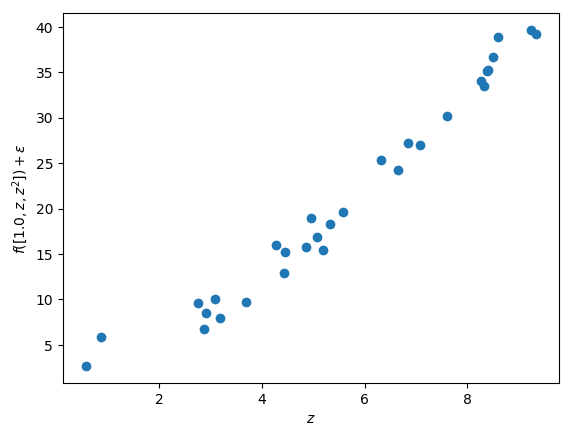

PyObject Text(29.88125000000001, 0.5, '$f([1.0, z, z^2]) + \\epsilon$')

In [5]:
using PyPlot, ForneyLab, LinearAlgebra

# Parameters
Σ = 1e5 * Diagonal(I,3) # Covariance matrix of prior on w
σ2 = 2.0         # Noise variance

# Generate data set
w = [1.0; 2.0; 0.25]
N = 30
z = 10.0*rand(N)
x_train = [[1.0; z; z^2] for z in z] # Feature vector x = [1.0; z; z^2]
f(x) = (w'*x)[1]
y_train = map(f, x_train) + sqrt(σ2)*randn(N) # y[i] = w' * x[i] + ϵ
scatter(z, y_train); xlabel(L"z"); ylabel(L"f([1.0, z, z^2]) + \epsilon")


Now build the factor graph in ForneyLab, perform sum-product message passing and plot results (mean of posterior).

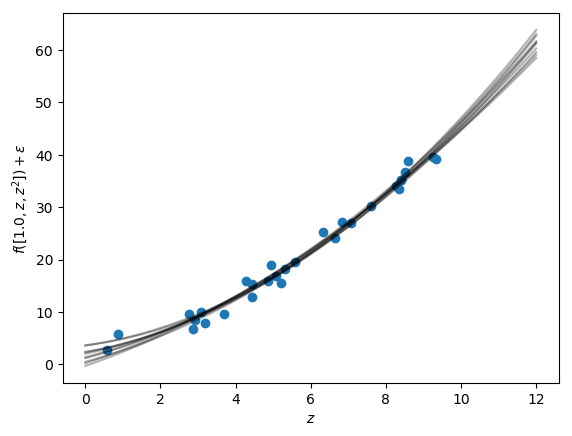

Posterior distribution of w: 𝒩(xi=[3.18e+02, 2.18e+03, 1.63e+04], w=[[15.00, 83.82, 5.57e+02][83.82, 5.57e+02, 4.06e+03][5.57e+02, 4.06e+03, 3.13e+04]])



In [6]:
# Build factorgraph

fg = FactorGraph()
@RV w ~ GaussianMeanVariance(constant(zeros(3)), constant(Σ, id=:Σ), id=:w) # p(w)
for t=1:N
    x_t = Variable(id=:x_*t)
    d_t = Variable(id=:d_*t) # d=w'*x
    DotProduct(d_t, x_t, w) # p(f|w,x)
    @RV y_t ~ GaussianMeanVariance(d_t, constant(σ2, id=:σ2_*t), id=:y_*t) # p(y|d)
    placeholder(x_t, :x, index=t, dims=(3,))
    placeholder(y_t, :y, index=t);
end

# Build and run message passing algorithm
eval(Meta.parse(sumProductAlgorithm(w)))
data = Dict(:x => x_train, :y => y_train)
w_posterior_dist = step!(data)[:w]

# Plot result
println("Posterior distribution of w: $(w_posterior_dist)")
scatter(z, y_train); xlabel(L"z"); ylabel(L"f([1.0, z, z^2]) + \epsilon");
z_test = collect(0:0.2:12)
x_test = [[1.0; z; z^2] for z in z_test]
for sample=1:10
    w = ForneyLab.sample(w_posterior_dist)
    f_est(x) = (w'*x)[1]
    plot(z_test, map(f_est, x_test), "k-", alpha=0.3);
end

### Other Message Passing Algorithms

- The Sum-Product (SP) update rule implements perfect Bayesian inference. 
- Sometimes, the SP update rule is not analytically solvable. 
- Fortunately, for many well-known Bayesian approximation methods, a message passing update rule can be created, e.g. [Variational Message Passing](https://en.wikipedia.org/wiki/Variational_message_passing) (VMP) for variational inference. 
- In general, all of these message passing algorithms can be interpreted as minimization of a constrained free energy (e.g., see [Zhang et al. (2017)](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Zhang-2017-Unifying-Message-Passing-Algorithms.pdf), and hence these message passing schemes comply with [Caticha's Method of Maximum Relative Entropy](https://arxiv.org/abs/1011.0723), which, as discussed in the [variational Bayes lesson](https://nbviewer.jupyter.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Latent-Variable-Models-and-VB.ipynb) is the proper way for updating beliefs. 
- Different message passing updates rules can be combined to get a hybrid inference method in one model. 

### Summary

- The foregoing message update rules can be worked out in closed-form and put into tables (e.g., see Tables 1 through 6 in [Loeliger, 2007](./files/Loeliger-2007-The-factor-graph-approach-to-model-based-signal-processing.pdf) for many standard factors such as additions, fixed-gain multiplications and branching (equality nodes), thus creating a completely **automatable inference framework**.

- If the update rules for all node types in a graph have been tabulated, then inference by message passing comes down to executing a set of table-lookup operations. This also works for large graphs (where 'manual' inference becomes intractable).

- If the graph contains no cycles, the Sum-Product Algorithm computes **exact** marginals for all hidden variables.

- If the graph contains cycles, we have in principle an infinite tree without terminals. In this case, the SP Algorithm is not guaranteed to find exact marginals. In practice, if we apply the SP algorithm for just a few iterations we often find satisfying approximate marginals.   

# <center>OPTIONAL SLIDES</center>

### Sum-Product Messages for the Equality Node

- Let´s compute the SP messages for the **equality node** $f_=(x,y,z) = \delta(z-x)\delta(z-y)$: 

<img src="./figures/ffg-equality-node.png" width="200px">

$$\begin{align*}
\overrightarrow{\mu}_{Z}(z) &= \iint  \overrightarrow{\mu}_{X}(x) \overrightarrow{\mu}_{Y}(y) \,\delta(z-x)\delta(z-y) \,\mathrm{d}x \mathrm{d}y \\
   &=  \overrightarrow{\mu}_{X}(z)  \int  \overrightarrow{\mu}_{Y}(y) \,\delta(z-y) \,\mathrm{d}y \\
   &=  \overrightarrow{\mu}_{X}(z) \overrightarrow{\mu}_{Y}(z) 
\end{align*}$$

- By symmetry, this also implies (for the same equality node) that

$$\begin{align*}
\overleftarrow{\mu}_{X}(x) &= \overrightarrow{\mu}_{Y}(x) \overleftarrow{\mu}_{Z}(x) \quad \text{and} \\
\overleftarrow{\mu}_{Y}(y) &= \overrightarrow{\mu}_{X}(y) \overleftarrow{\mu}_{Z}(y)\,.
\end{align*}$$

- Let us now consider the case of Gaussian messages $\overrightarrow{\mu}_{X}(x) = \mathcal{N}(\overrightarrow{m}_X,\overrightarrow{V}_X)$, $\overrightarrow{\mu}_{Y}(y) = \mathcal{N}(\overrightarrow{m}_Y,\overrightarrow{V}_Y)$ and $\overrightarrow{\mu}_{Z}(z) = \mathcal{N}(\overrightarrow{m}_Z,\overrightarrow{V}_Z)$. Let´s also define the precision matrices $\overrightarrow{W}_X \triangleq \overrightarrow{V}_X^{-1}$ and similarly for $Y$ and $Z$. Then applying the SP update rule leads to multiplication of two Gaussian distributions, resulting in 

$$\begin{align*}
\overrightarrow{W}_Z &= \overrightarrow{W}_X + \overrightarrow{W}_Y \\ 
\overrightarrow{W}_Z \overrightarrow{m}_z &= \overrightarrow{W}_X \overrightarrow{m}_X + \overrightarrow{W}_Y \overrightarrow{m}_Y
\end{align*}$$

- It follows that **message passing through an equality node is similar to applying Bayes rule**, i.e., fusion of two information sources. Does this make sense?

###  Sum-Product Messages for the Addition Node

- Next, consider an **addition node** $f_+(x,y,z) = \delta(z-x-y)$:  
<img src="./figures/ffg-addition-node.png" width="200px">

$$\begin{align*}
\overrightarrow{\mu}_{Z}(z) &= \iint  \overrightarrow{\mu}_{X}(x) \overrightarrow{\mu}_{Y}(y) \,\delta(z-x-y) \,\mathrm{d}x \mathrm{d}y \\
   &=  \int  \overrightarrow{\mu}_{X}(x) \overrightarrow{\mu}_{Y}(z-x) \,\mathrm{d}x \,, 
\end{align*}$$
i.e., $\overrightarrow{\mu}_{Z}$ is the convolution of the messages $\overrightarrow{\mu}_{X}$ and $\overrightarrow{\mu}_{Y}$.

- Of course, for Gaussian messages, these update rules evaluate to

$$\begin{align*}
\overrightarrow{m}_Z = \overrightarrow{m}_X + \overrightarrow{m}_Y \,,\,\text{and}\,\,\overrightarrow{V}_z = \overrightarrow{V}_X + \overrightarrow{V}_Y \,.
\end{align*}$$

- <div class="exercise"><b>Exercise</b>: For the same summation node, work out the SP update rule for the *backward* message $\overleftarrow{\mu}_{X}(x)$ as a function of $\overrightarrow{\mu}_{Y}(y)$ and  $\overleftarrow{\mu}_{Z}(z)$? And further refine the answer for Gaussian messages. </div>   

###  Sum-Product Messages for Multiplication Nodes
- Next, let us consider a **multiplication** by a fixed (invertible matrix) gain $f_A(x,y) = \delta(y-Ax)$

<img src="./figures/ffg-gain-node.png" width="200px">

$$\begin{align*}
\overrightarrow{\mu}_{Y}(y) = \int  \overrightarrow{\mu}_{X}(x) \,\delta(y-Ax) \,\mathrm{d}x = \overrightarrow{\mu}_{X}(A^{-1}y) \,.
\end{align*}$$

- For a Gaussian message input message $\overrightarrow{\mu}_{X}(x) = \mathcal{N}(\overrightarrow{m}_{X},\overrightarrow{V}_{X})$, the output message is also Gaussian with 
$$\begin{align*}
\overrightarrow{m}_{Y} = A\overrightarrow{m}_{X} \,,\,\text{and}\,\,
\overrightarrow{V}_{Y} = A\overrightarrow{V}_{X}A^T
\end{align*}$$
since 
$$\begin{align*}
\overrightarrow{\mu}_{Y}(y) &= \overrightarrow{\mu}_{X}(A^{-1}y) \\
  &\propto \exp \left( -\frac{1}{2} \left( A^{-1}y - \overrightarrow{m}_{X}\right)^T \overrightarrow{V}_{X}^{-1} \left(  A^{-1}y - \overrightarrow{m}_{X}\right)\right) \\
   &= \exp \left( -\frac{1}{2} \left( y - A\overrightarrow{m}_{X}\right)^T A^{-T}\overrightarrow{V}_{X}^{-1} A \left( y - A\overrightarrow{m}_{X}\right)\right) \\
  &\propto  \mathcal{N}(A\overrightarrow{m}_{X},A\overrightarrow{V}_{X}A^T) \,.
\end{align*}$$

- <div class="exercise"><b>Excercise</b>: Proof that, for the same factor $\delta(y-Ax)$ and Gaussian messages, the (backward) sum-product message $\overleftarrow{\mu}_{X}$ is given by 
$$\begin{align*}
\overleftarrow{\xi}_{X} &= A^T\overleftarrow{\xi}_{Y} \\
\overleftarrow{W}_{X} &= A^T\overleftarrow{W}_{Y}A
\end{align*}$$
where $\overleftarrow{\xi}_X \triangleq \overleftarrow{W}_X \overleftarrow{m}_X$ and $\overleftarrow{W}_{X} \triangleq \overleftarrow{V}_{X}^{-1}$ (and similarly for $Y$).</div>


#### CODE EXAMPLE

Let's calculate the Gaussian forward and backward messages for the addition node in ForneyLab. <img src="./figures/ffg-addition-node.png" width="200px">

In [2]:
# Forward message towards Z
fg = FactorGraph()
@RV x ~ GaussianMeanVariance(constant(1.0), constant(1.0), id=:x) 
@RV y ~ GaussianMeanVariance(constant(2.0), constant(1.0), id=:y)
@RV z = x + y; z.id = :z

eval(Meta.parse(sumProductAlgorithm(z, name="_z_fwd")))
msg_forward_Z = step_z_fwd!(Dict())[:z]
print("Forward message on Z: $(msg_forward_Z)")

# Backward message towards X
fg = FactorGraph()
@RV x = Variable(id=:x)
@RV y ~ GaussianMeanVariance(constant(2.0), constant(1.0), id=:y)
@RV z = x + y
GaussianMeanVariance(z, constant(3.0), constant(1.0), id=:z) 

eval(Meta.parse(sumProductAlgorithm(x, name="_x_bwd")))
msg_backward_X = step_x_bwd!(Dict())[:x]
print("Backward message on X: $(msg_backward_X)")

Forward message on Z: 𝒩(m=3.00, v=2.00)
Backward message on X: 𝒩(m=1.00, v=2.00)


#### CODE EXAMPLE

In the same way we can also investigate the forward and backward messages for the gain node <img src="./figures/ffg-gain-node.png" width="200px">

In [3]:
# Forward message towards Y
fg = FactorGraph()
@RV x ~ GaussianMeanVariance(constant(1.0), constant(1.0), id=:x)
@RV y = constant(4.0) * x; y.id = :y

eval(Meta.parse(sumProductAlgorithm(y, name="_y_fwd")))
msg_forward_Y = step_y_fwd!(Dict())[:y]
print("Forward message on Y: $(msg_forward_Y)")

Forward message on Y: 𝒩(m=4.00, v=16.00)


 
 ### Example
 
 - Consider a generative model 
$$p(x,y_1,y_2) = p(x)\,p(y_1|x)\,p(y_2|x) .$$ 
  - This model expresses the assumption that $Y_1$ and $Y_2$ are independent measurements of $X$.

<img src="./figures/ffg-observations.png" width="300px">

 
- Assume that we are interested in the posterior for $X$ after observing $Y_1= \hat y_1$ and $Y_2= \hat y_2$. The posterior for $X$ can be inferred by applying the sum-product algorithm to the following graph:

<img src="./figures/ffg-observations-2.png" width="450px">

 - (Note that) we usually draw terminal nodes for observed variables in the graph by smaller solid-black squares. This is just to help the visualization of the graph, since the computational rules are no different than for other nodes. 

#### CODE EXAMPLE

We'll use ForneyLab, a factor graph toolbox for Julia, to build the above graph, and perform sum-product message passing to infer the posterior $p(x|y_1,y_2)$. We assume $p(y_1|x)$ and $p(y_2|x)$ to be Gaussian likelihoods with known variances:
$$\begin{align*}
    p(y_1\,|\,x) &= \mathcal{N}(y_1\,|\,x, v_{y1}) \\
    p(y_2\,|\,x) &= \mathcal{N}(y_2\,|\,x, v_{y2})
\end{align*}$$
Under this model, the posterior is given by:
$$\begin{align*}
    p(x\,|\,y_1,y_2) &\propto \overbrace{p(y_1\,|\,x)\,p(y_2\,|\,x)}^{\text{likelihood}}\,\overbrace{p(x)}^{\text{prior}} \\
    &=\mathcal{N}(x\,|\,\hat{y}_1, v_{y1})\, \mathcal{N}(x\,|\,\hat{y}_2, v_{y2}) \, \mathcal{N}(x\,|\,m_x, v_x) 
\end{align*}$$
so we can validate the answer by solving the Gaussian multiplication manually.

In [5]:
using ForneyLab 

# Data
y1_hat = 1.0
y2_hat = 2.0

# Construct the factor graph
fg = FactorGraph()
@RV x  ~ GaussianMeanVariance(constant(0.0), constant(4.0), id=:x) # Node p(x)
@RV y1 ~ GaussianMeanVariance(x, constant(1.0))            # Node p(y1|x)
@RV y2 ~ GaussianMeanVariance(x, constant(2.0))            # Node p(y2|x)
Clamp(y1, y1_hat)                  # Terminal (clamp) node for y1
Clamp(y2, y2_hat)                  # Terminal (clamp) node for y2
# draw(fg) # draw the constructed factor graph

# Perform sum-product message passing
eval(Meta.parse(sumProductAlgorithm(x, name="_algo1"))) # Automatically derives a message passing schedule
x_marginal = step_algo1!(Dict())[:x] # Execute algorithm and collect marginal distribution of x
println("Sum-product message passing result: p(x|y1,y2) = 𝒩($(mean(x_marginal)),$(var(x_marginal)))")

# Calculate mean and variance of p(x|y1,y2) manually by multiplying 3 Gaussians (see lesson 4 for details)
v = 1 / (1/4 + 1/1 + 1/2)
m = v * (0/4 + y1_hat/1.0 + y2_hat/2.0)
println("Manual result: p(x|y1,y2) = 𝒩($(m), $(v))")

Sum-product message passing result: p(x|y1,y2) = 𝒩(1.1428571428571428,0.5714285714285714)
Manual result: p(x|y1,y2) = 𝒩(1.1428571428571428, 0.5714285714285714)


In [4]:
# Backward message towards X
fg = FactorGraph()
x = Variable(id=:x)
@RV y = constant(4.0) * x
GaussianMeanVariance(y, constant(2.0), constant(1.0))

eval(Meta.parse(sumProductAlgorithm(x, name="_x_fwd2")))
msg_backward_X = step_x_fwd2!(Dict())[:x]
print("Backward message on X: $(msg_backward_X)")

Backward message on X: 𝒩(xi=8.00, w=16.00)


### The Local Free Energy in a Factor Graph 

- Consider an edge $x_j$ in a Forney-style factor graph for a generative model $p(x) = p(x_1,x_2,\ldots,x_N)$.



- Assume that the graph structure (factorization) is specified by
$$
p(x) = \prod_{a=1}^M p_a(x_a)
$$
where $a$ is a set of indices.
- Also, we assume a mean-field approximation for the posterior:
$$
q(x) = \prod_{i=1}^N q_i(x_i)
$$
and consequently a corresponding free energy functional  
$$\begin{align*}
F[q] &= \sum_x q(x) \log \frac{q(x)}{p(x)} \\
  &= \sum_i \sum_{x_i} \left(\prod_{i=1}^N q_i(x_i)\right) \log \frac{\prod_{i=1}^N q_i(x_i)}{\prod_{a=1}^M p_a(x_a)}
\end{align*}$$

- With these assumptions, it can be shown that the FE evaluates to (exercise)
$$
F[q] = \sum_{a=1}^M \underbrace{\sum_{x_a} \left( \prod_{j\in N(a)} q_j(x_j)\cdot \left(-\log p_a(x_a)\right) \right) }_{\text{node energy }U[p_a]} - \sum_{i=1}^N \underbrace{\sum_{x_i} q_i(x_i) \log \frac{1}{q_i(x_i)}}_{\text{edge entropy }H[q_i]}
$$

- In words, the FE decomposes into a sum of (expected) energies for the nodes minus the entropies on the edges. 
 

### Variational Message Passing

- Let us now consider the local free energy that is associated with edge corresponding to $x_j$. 
  
  <img src="./figures/VMP-two-nodes.png" width="600">
  
  
- Apparently (see previous slide), there are three contributions to the free energy for $x_j$:
    - one entropy term for the edge $x_j$
    - two energy terms: one for each node that attaches to $x_j$ (in the figure: nodes $p_a$ and $p_b$)
    
- The local free energy for $x_j$ can be written as (exercise)
  $$
  F[q_j] \propto \sum_{x_j} q(x_j) \log \frac{q_j(x_j)}{\nu_a(x_j)\cdot \nu_b(x_j)}
  $$
  where
  $$\begin{align*} 
  \nu_a(x_j) &\propto \exp\left( \mathbb{E}_{q_{k}}\left[ \log p_a(x_a)\right]\right) \\
  \nu_b(x_j) &\propto \exp\left( \mathbb{E}_{q_{l}}\left[ \log p_b(x_b)\right]\right) 
  \end{align*}$$
  and $\mathbb{E}_{q_{k}}\left[\cdot\right]$ is an expectation w.r.t. all $q(x_k)$ with $k \in N(a)\setminus {j}$.
  
- $\nu_a(x_j)$ and $\nu_b(x_j)$  can be locally computed in nodes $a$ and $b$ respectively and can be interpreted as colliding messages over edge $x_j$. 
  
- Local free energy minimization is achieved by setting
  $$
  q_j(x_j) \propto \nu_a(x_j) \cdot \nu_b(x_j)
  $$
  
- Note that message $\nu_a(x_j)$ depends on posterior beliefs over incoming edges ($k$) for node $a$, and in turn, the message from node $a$ towards edge $x_k$ depends on the belief $q_j(x_j)$. I.o.w., direct mutual dependencies exist between posterior beliefs over edges that attach to the same node. 
  
- These considerations lead to the [Variational Message Passing](https://en.wikipedia.org/wiki/Variational_message_passing) procedure, which is an iterative free energy minimization procedure that can be executed completely through locally computable messages.  

- Procedure VMP, see [Dauwels (2007), section 3](https://github.com/bertdv/BMLIP/blob/master/lessons/notebooks/files/Dauwels-2007-on-variational-message-passing-on-factor-graphs)
  > 1. Initialize all messages $q$ and $ν$, e.g., $q(\cdot) \propto 1$ and $\nu(\cdot) \propto 1$. <br/>
  > 2. Select an edge $z_k$ in the factor graph of $f(z_1,\ldots,z_m)$.<br/>
  > 3. Compute the two messages $\overrightarrow{\nu}(z_k)$ and $\overleftarrow{\nu}(z_k)$ by applying the following generic rule:
  $$
  \overrightarrow{\nu}(y) \propto \exp\left( \mathbb{E}_{q}\left[ \log g(x_1,\dots,x_n,y)\right] \right) 
  $$
  > 4. Compute the marginal $q(z_k)$
  $$
  q(z_k) \propto \overrightarrow{\nu}(z_k) \overleftarrow{\nu}(z_k)
  $$
  and send it to the two nodes connected to the edge $x_k$.<br/>
  > 5. Iterate 2–4 until convergence. 

### The Bethe Free Energy and Belief Propagation

- We showed that, under mean field assumptions, the FE can be decomposed into a sum of local FE contributions for the nodes ($a$) and edges ($i$):
$$
F[q] = \sum_{a=1}^M \underbrace{\sum_{x_a} \left( \prod_{j\in N(a)} q_j(x_j)\cdot \left(-\log p_a(x_a)\right) \right) }_{\text{node energy }U[p_a]} - \sum_{i=1}^N \underbrace{\sum_{x_i} q_i(x_i) \log \frac{1}{q_i(x_i)}}_{\text{edge entropy }H[q_i]}
$$

- The mean field assumption is very strong and may lead to large inference costs. A more relaxed assumption is to allow joint posterior beliefs over the variables that attach to a node. This idea is expressed by the _Bethe_ Free Energy:
$$
F_B[q] = \sum_{a=1}^M \left( \sum_{x_a} q_a(x_a) \log \frac{q_a(x_a)}{p_a(x_a)} \right)  - \sum_{i=1}^N (d_i - 1) \sum_{x_i} q_i(x_i) \log {q_i(x_i)}
$$
where $q_a(x_a)$ is the posterior *joint* belief over the variables $x_a$ (i.e., the set of variables that attach to node $a$), $q_i(x_i)$ is the posterior marginal belief over the variable $x_i$ and $d_i$ is the number of factor nodes that link to edge $i$. Moreover, $q_a(x_a)$ and $q_i(x_i)$ are constrained to obey the following equalities:
$$
    \sum_{x_a \backslash x_i} q_a(x_a) = q_i(x_i), ~~~ \forall i, \forall a \\
    \sum_{x_i} q_i(x_i) = 1, ~~~ \forall i
$$

- Given these constraints, we form the Lagrangian by augmenting the _Bethe_ Free Energy functional with the constraints 
$$
L[q] = F_B[q] + \sum_{a,i} \lambda_{ai}(x_i) \left(q_i(x_i) - \sum_{x_a\backslash x_i} q(x_a) \right) + \sum_{i} \lambda_i \left( 1 - \sum_{x_i}q_i(x_i) \right)
$$

- The stationary solutions for this Lagrangian are given by
$$
q_a(x_a) \propto f_a(x_a) \exp\left(\sum_{i \in N(a)} \lambda_{ai}(x_i)\right) \\ 
q_i(x_i) \propto \exp\left(\sum_{a \in N(i)} \lambda_{ai}(x_i)\right) ^{\frac{1}{d_i - 1}}
$$
where $N(i)$ denotes the factor nodes that have $x_i$ in their arguments and $N(a)$ denotes the set of variables in the argument of $f_a$. 

- <font color=red> TO BE FINISHED ...</font>

In [1]:
open("../../styles/aipstyle.html") do f display("text/html", read(f, String)) end


<!--
This HTML file contains custom styles and some javascript.
Include it a Jupyter notebook for improved rendering.
-->

<!-- Fonts -->
 
 
 
 
 

<!-- Custom style -->


<!-- MathJax styling -->